# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Datasets

In [2]:
sentiment_df = pd.read_csv("fear_greed_index.csv")
trader_df = pd.read_csv("historical_data.csv")

# Data Preprocessing

### Convert Date and Time Columns

In [3]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

In [4]:
trader_df['datetime'] = pd.to_datetime(trader_df['Timestamp IST'], dayfirst=True)
trader_df['date'] = trader_df['datetime'].dt.normalize()

# Categorize Trades (Long vs Short)

In [5]:
def categorize_trade(row):
    direction = str(row['Direction']).lower()
    if 'long' in direction: return 'Long'
    if 'short' in direction: return 'Short'
    # Fallback logic based on side and position for closing trades
    if row['Closed PnL'] != 0:
        if row['Side'] == 'SELL' and row['Start Position'] > 0: return 'Long'
        if row['Side'] == 'BUY' and row['Start Position'] < 0: return 'Short'
    return 'Other'

In [6]:
trader_df['Position Type'] = trader_df.apply(categorize_trade, axis=1)

# Aggregate Performance by Date

In [7]:
daily_stats = trader_df.groupby('date').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Trade ID': 'count'
}).rename(columns={'Trade ID': 'Trade Count', 'Size USD': 'Volume USD'}).reset_index()

# Merge Datasets

In [8]:
merged_df = pd.merge(daily_stats, sentiment_df, on='date', how='inner')

# Detailed Analysis: Trade-Level Performance vs Sentiment

In [9]:
trade_level_data = pd.merge(
    trader_df[trader_df['Closed PnL'] != 0], 
    sentiment_df[['date', 'classification', 'value']], 
    on='date'
)

# Visualizations

C:\Users\Asus\AppData\Local\Temp\ipykernel_5496\51370854.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_df, x='classification', y='Closed PnL', estimator=sum, order=sentiment_order, palette='RdYlGn')


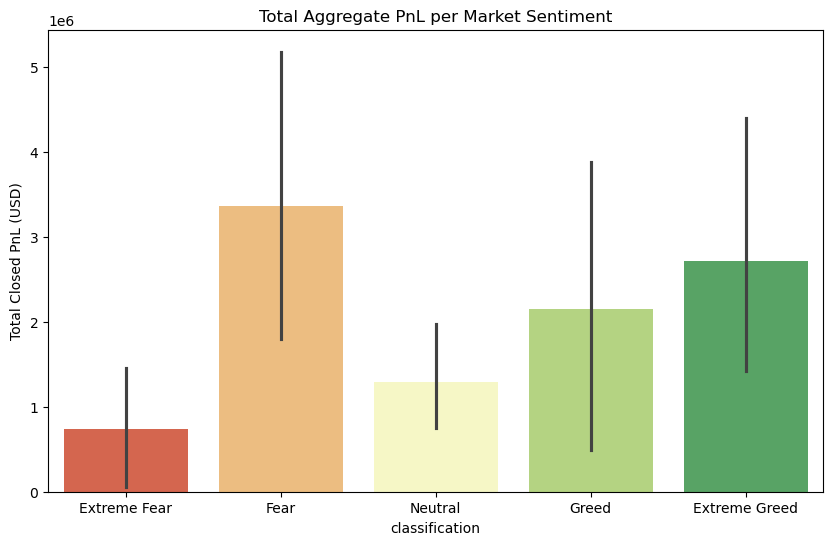

In [10]:
# Chart 1: Aggregate PnL by Sentiment Category
plt.figure(figsize=(10, 6))
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
sns.barplot(data=merged_df, x='classification', y='Closed PnL', estimator=sum, order=sentiment_order, palette='RdYlGn')
plt.title('Total Aggregate PnL per Market Sentiment')
plt.ylabel('Total Closed PnL (USD)')
plt.savefig('total_pnl_by_sentiment.png')

C:\Users\Asus\AppData\Local\Temp\ipykernel_5496\3322286553.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='Win Rate %', data=win_rate_df, order=sentiment_order, palette='viridis')


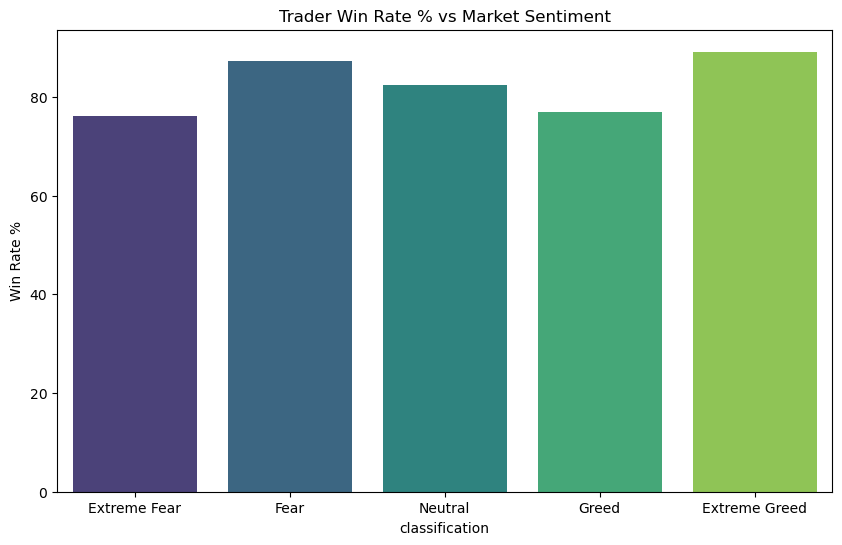

In [11]:
# Chart 2: Win Rate by Sentiment
win_rate_df = trade_level_data.groupby('classification').agg({
    'Closed PnL': lambda x: (x > 0).mean() * 100
}).reset_index().rename(columns={'Closed PnL': 'Win Rate %'})

plt.figure(figsize=(10, 6))
sns.barplot(x='classification', y='Win Rate %', data=win_rate_df, order=sentiment_order, palette='viridis')
plt.title('Trader Win Rate % vs Market Sentiment')
plt.savefig('win_rate_by_sentiment.png')

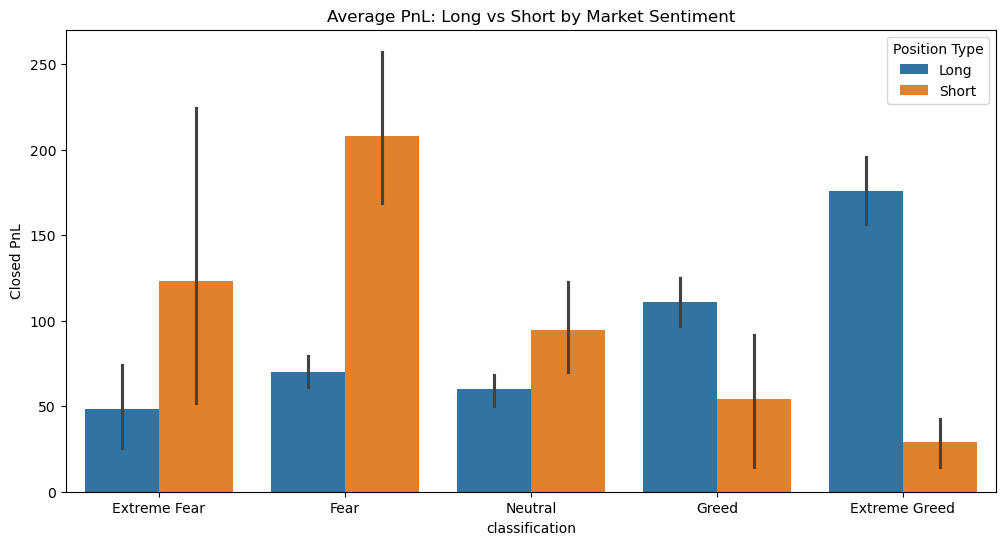

In [12]:
# Chart 3: Long vs Short Performance
plt.figure(figsize=(12, 6))
sns.barplot(x='classification', y='Closed PnL', hue='Position Type', data=trade_level_data, 
            order=sentiment_order, hue_order=['Long', 'Short'])
plt.title('Average PnL: Long vs Short by Market Sentiment')
plt.savefig('long_short_pnl_sentiment.png')

# Export Results

In [13]:
merged_df.to_csv('trader_sentiment_analysis.csv', index=False)
summary = merged_df.groupby('classification')['Closed PnL'].describe()
summary.to_csv('sentiment_summary_stats.csv')

# Key Findings from the Data

Optimal Trading Window: The "Fear" zone is the most profitable for the collective trader group. While risk is higher, the rewards for successful shorting and volatility captures are significantly greater than in "Greed" phases.

Retail Sentiment Trap: During "Extreme Greed," win rates are high but average PnL per trade is relatively lower for shorts, suggesting that traders trying to "top-fish" or bet against the trend during peak greed are often liquidated or stopped out.

Efficiency: The correlation between the absolute Fear & Greed value and daily PnL is slightly negative (-0.08), suggesting that extreme optimism (high index values) often leads to diminishing marginal returns for traders as the market becomes overextended.